In [1]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
import logging
from utils.logger_utils import setup_clean_logger, mute_external_loggers

# Set up a clean logger for your notebook
logger = setup_clean_logger("notebook", logging.INFO)
logger.info("Notebook started successfully.")

# Mute logs from sisepuede to avoid duplication
mute_external_loggers(["sisepuede"])


##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

2025-08-28 11:45:11,533 - INFO - Notebook started successfully.


In [2]:
%load_ext autoreload
%autoreload 2

### Initial Set up

Make sure to edit the config yaml under ssp_modeling/config_files/config.yaml

You can also create a new config yaml



In [3]:
# Set up dir paths

CURR_DIR_PATH = pathlib.Path(os.getcwd())
SSP_MODELING_DIR_PATH = CURR_DIR_PATH.parent
PROJECT_DIR_PATH = SSP_MODELING_DIR_PATH.parent
DATA_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("input_data")
RUN_OUTPUT_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("ssp_run_output")
SCENARIO_MAPPING_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("scenario_mapping")
CONFIG_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("config_files")
TRANSFORMATIONS_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("transformations")
MISC_DIR_PATH = SSP_MODELING_DIR_PATH.joinpath("misc")
STRATEGIES_DEFINITIONS_FILE_PATH = TRANSFORMATIONS_DIR_PATH.joinpath("strategy_definitions.csv")
STRATEGY_MAPPING_FILE_PATH = MISC_DIR_PATH.joinpath("strategy_mapping.yaml")

In [4]:
from ssp_transformations_handler.GeneralUtils import GeneralUtils
from ssp_transformations_handler.TransformationUtils import TransformationYamlProcessor, StrategyCSVHandler

# Initialize general utilities
g_utils = GeneralUtils()

In [5]:
# Load config file, double check your parameters are correct

YAML_FILE_PATH = os.path.join(CONFIG_DIR_PATH, "config.yaml")
config_params = g_utils.read_yaml(YAML_FILE_PATH)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']
energy_model_flag = config_params['energy_model_flag']
set_lndu_reallocation_factor_to_zero_flag = config_params['set_lndu_reallocation_factor_to_zero']

# Print config parameters
logger.info(f"Country name: {country_name}")
logger.info(f"SSP input file name: {ssp_input_file_name}")
logger.info(f"SSP transformation CW: {ssp_transformation_cw}")
logger.info(f"Energy model flag: {energy_model_flag}")
logger.info(f"Set lndu reallocation factor to zero flag: {set_lndu_reallocation_factor_to_zero_flag}")

2025-08-28 11:45:12,244 - INFO - Country name: egypt
2025-08-28 11:45:12,244 - INFO - SSP input file name: EGY_real_data_20250828.csv
2025-08-28 11:45:12,244 - INFO - SSP transformation CW: None
2025-08-28 11:45:12,244 - INFO - Energy model flag: True
2025-08-28 11:45:12,245 - INFO - Set lndu reallocation factor to zero flag: True


In [6]:
# Set up SSP objects

INPUT_FILE_PATH = DATA_DIR_PATH.joinpath(ssp_input_file_name)

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [7]:
##  BUILD BASE INPUTS
df_inputs_raw = pd.read_csv(INPUT_FILE_PATH)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [8]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw)

Columns in df_example but not in df_input: {'pij_lndu_pastures_to_forests_primary', 'nemomod_entc_emissions_activity_ratio_scalar_fp_hydrogen_reformation_ccs_co2', 'ef_frst_sequestration_young_secondary_kt_co2_ha', 'ef_lndu_conv_grasslands_to_pastures_gg_co2_ha', 'frac_lndu_increasing_net_exports_met_pastures', 'area_lndu_infimum_wetlands_ha', 'ef_lndu_conv_shrublands_to_wetlands_gg_co2_ha', 'ef_lndu_conv_forests_secondary_to_flooded_gg_co2_ha', 'pij_lndu_other_to_flooded', 'ef_lndu_conv_forests_secondary_to_shrublands_gg_co2_ha', 'ef_lndu_conv_flooded_to_grasslands_gg_co2_ha', 'ef_lndu_conv_settlements_to_shrublands_gg_co2_ha', 'ef_lndu_conv_forests_primary_to_shrublands_gg_co2_ha', 'frac_lndu_improved_pastures', 'ef_lndu_conv_flooded_to_forests_primary_gg_co2_ha', 'pij_lndu_shrublands_to_forests_secondary', 'pij_lndu_grasslands_to_shrublands', 'nemomod_entc_emissions_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_tonne_co2_per_tj', 'frac_lndu_soil_mineral_shrublands', 'ef

In [9]:
# Ensure if time_period field exist
if 'time_period' not in df_inputs_raw.columns:
    logger.info("Adding 'time_period' column to df_inputs_raw")
    df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
else:
    logger.info("'time_period' column already exists in df_inputs_raw")

2025-08-28 11:45:12,939 - INFO - 'time_period' column already exists in df_inputs_raw


In [10]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw_complete = g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
df_inputs_raw_complete = g_utils.remove_additional_cols(df_inputs_example, df_inputs_raw_complete.copy())
df_inputs_raw_complete.head()

,frac_lvst_mm_sheep_liquid_slurry,frac_lvst_mm_mules_anaerobic_digester,pij_lndu_grasslands_to_grasslands,pij_lndu_forests_mangroves_to_grasslands,frac_agrc_vegetables_and_vines_cl2_wet,frac_lvst_mm_mules_dry_lot,frac_lvst_mm_cattle_dairy_deep_bedding,ef_lndu_conv_wetlands_to_forests_secondary_gg_co2_ha,frac_agrc_pulses_cl2_wet,ef_lndu_conv_other_to_forests_primary_gg_co2_ha,...,nemomod_entc_output_activity_ratio_fuel_production_fp_natural_gas_liquefaction_natural_gas_unprocessed,exports_enfu_pj_fuel_natural_gas_liquid,frac_enfu_fuel_demand_imported_pj_fuel_natural_gas_liquid,nemomod_entc_capital_cost_fp_natural_gas_liquefaction_mm_usd_per_gw,nemomod_entc_fixed_cost_fp_natural_gas_liquefaction_mm_usd_per_gw,nemomod_entc_emissions_activity_ratio_fuel_production_fp_natural_gas_liquefaction_tonne_ch4_per_tj,nemomod_entc_emissions_activity_ratio_fuel_production_fp_natural_gas_liquefaction_tonne_co2_per_tj,nemomod_entc_emissions_activity_ratio_fuel_production_fp_natural_gas_liquefaction_tonne_n2o_per_tj,nemomod_entc_input_activity_ratio_fuel_production_fp_natural_gas_liquefaction_electricity,nemomod_entc_input_activity_ratio_fuel_production_fp_natural_gas_liquefaction_natural_gas
0,0.0,0.0,0.901905,0.000000,0.0,0.235,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0.073069,5.4,0.00005,0.000001,1.124874
1,0.0,0.0,0.955499,0.000000,0.0,0.235,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0.073069,5.4,0.00005,0.000001,1.124874
2,0.0,0.0,0.901047,0.000000,0.0,0.235,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0.073069,5.4,0.00005,0.000001,1.124874
3,0.0,0.0,0.948052,0.001948,0.0,0.235,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0.073069,5.4,0.00005,0.000001,1.124874
4,0.0,0.0,0.925891,0.001955,0.0,0.235,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0.073069,5.4,0.00005,0.000001,1.124874


In [11]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df_example but not in df_input: set()
Columns in df_input but not in df_example: set()


In [12]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].head()

0    egypt
1    egypt
2    egypt
3    egypt
4    egypt
Name: region, dtype: object

## Let's Modify the  LNDU Reallocation factor

In [13]:
if set_lndu_reallocation_factor_to_zero_flag:
    df_inputs_raw_complete['lndu_reallocation_factor'] = 0

df_inputs_raw_complete['lndu_reallocation_factor'].mean()

np.float64(0.0)

#  Let's try building transformations using this


In [14]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [15]:
# set an ouput path and instantiate
if not TRANSFORMATIONS_DIR_PATH.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        TRANSFORMATIONS_DIR_PATH,
    )
else:
    logger.info(f"Directory {TRANSFORMATIONS_DIR_PATH} already exists. Skipping instantiation.")


2025-08-28 11:45:13,406 - INFO - Directory /Users/tony/Documents/sisepuede_modeling/ssp_egypt/ssp_modeling/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [16]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

if ssp_transformation_cw is None:
    logger.warning("ssp_transformation_cw is not defined. Please check your config file.")
else:
    logger.info(f"Using transformation file: {ssp_transformation_cw}")
    cw_file_path = os.path.join(SCENARIO_MAPPING_DIR_PATH, ssp_transformation_cw)
    logger.info(f"Transformation file path: {cw_file_path}")
    excel_yaml_handler = TransformationYamlProcessor(scenario_mapping_excel_path=cw_file_path, yaml_dir_path=TRANSFORMATIONS_DIR_PATH)

2025-08-28 11:45:13,418 - WARNING - ssp_transformation_cw is not defined. Please check your config file.


In [17]:
# This creates transformation yaml files for each strategy in the excel file
if ssp_transformation_cw is not None:
    logger.info("Processing YAML files...")
    excel_yaml_handler.process_yaml_files()
else:
    logger.warning("ssp_transformation_cw is not defined. Please check your config file.")

2025-08-28 11:45:13,428 - WARNING - ssp_transformation_cw is not defined. Please check your config file.


In [18]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct

if ssp_transformation_cw is not None:
    logger.info("Loading transformations per strategy dictionary...")
    transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
    transformation_per_strategy_dict
    logger.info(f"Loaded transformations for strategies: {transformation_per_strategy_dict.keys()}")
else:
    logger.warning("No transformation handler available. Please check your config file.")

2025-08-28 11:45:13,438 - WARNING - No transformation handler available. Please check your config file.


### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [19]:
# Creating new strategies by updating the strategy_definitions file.

if ssp_transformation_cw is not None:
    # You can edit this to add yours, as many as you want.
    csv_handler = StrategyCSVHandler(csv_file_path=STRATEGIES_DEFINITIONS_FILE_PATH, 
                                     yaml_dir_path=TRANSFORMATIONS_DIR_PATH, 
                                     yaml_mapping_file=STRATEGY_MAPPING_FILE_PATH, 
                                     transformation_per_strategy_dict=transformation_per_strategy_dict)

    #csv_handler.add_strategy(strategy_group='PFLO', description='NDC BaU', yaml_file_suffix='BaU')
    csv_handler.add_strategy(strategy_group='PFLO', description='NDC', yaml_file_suffix='NDC')
    csv_handler.add_strategy(strategy_group='PFLO', description='Net Zero', yaml_file_suffix='NZ')
    csv_handler.add_strategy(strategy_group='PFLO', description='S BAU', yaml_file_suffix='BAU')
else:
    logger.warning("No transformation handler available. Please check your config file.")


2025-08-28 11:45:13,447 - WARNING - No transformation handler available. Please check your config file.


In [20]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6002]

### We finished adding new transformation files and strategies so lets load them back

In [21]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    TRANSFORMATIONS_DIR_PATH,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [22]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /Users/tony/Documents/sisepuede_modeling/ssp_egypt/ssp_modeling/transformations initialized in 1.51 seconds


In [23]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
66,4005,IPPU:DEC_PFCS,Singleton - Default Value - IPPU: Reduce use o...,NaN,TX:IPPU:DEC_PFCS,0
67,4006,IP:ALL,Sectoral Composite - IPPU,All (unique by transformer) IPPU transformations,TX:IPPU:DEC_CLINKER|TX:IPPU:DEC_DEMAND|TX:IPPU...,0
68,6000,PFLO:INC_HEALTHIER_DIETS,Singleton - Default Value - PFLO: Change diets,NaN,TX:PFLO:INC_HEALTHIER_DIETS,0
69,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0


##  Build our templates
- let's use the default variable groupings for LHS

In [24]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    # df_trajgroup = df_vargroups,
    # include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

0

# Finally, load SISEPUEDE so that we can run it

In [25]:
import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = not(energy_model_flag), # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    # try_exogenous_xl_types_in_variable_specification = True,
)

2025-08-28 11:45:17,127 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-08-28 11:45:17,128 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-08-28 11:45:17,128 - INFO - 	Setting export engine to 'csv'.
2025-08-28 11:45:17,129 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-08-28 11:45:17,129 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-08-28 11:45:17,129 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-08-28 11:45:17,129 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-08-28 11:45:17,129 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-08-28 11:45:17,130 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-08-28 11:45:17,130 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1461.4 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2025-08-28 11:45:46,887 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2025-08-28 11:45:46,901 - INFO - Successfully initialized SISEPUEDEModels.
2025-08-28 11:45:46,907 - INFO - Table ANALYSIS_METADATA successfully written to /opt/miniconda3/envs/ssp_egypt_env/lib/python3.11/site-

In [26]:
not(energy_model_flag)

False

In [27]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
    include_electricity_in_energy = energy_model_flag
)

2025-08-28 11:45:47,019 - INFO - 
***	STARTING REGION egypt	***

2025-08-28 11:45:47,643 - INFO - Trying run primary_id = 0 in region egypt
2025-08-28 11:45:47,644 - INFO - Running AFOLU model
2025-08-28 11:45:47,876 - INFO - AFOLU model run successfully completed
2025-08-28 11:45:47,877 - INFO - Running CircularEconomy model
2025-08-28 11:45:47,911 - INFO - CircularEconomy model run successfully completed
2025-08-28 11:45:47,911 - INFO - Running IPPU model
2025-08-28 11:45:47,966 - INFO - IPPU model run successfully completed
2025-08-28 11:45:47,966 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-28 11:45:47,989 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-28 11:45:48,030 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-28 11:45:48,031 - INFO - Running Energy model (Electricity and Fuel Production: trying to 

2025-28-Aug 11:45:48.380 Opened SQLite database at /opt/miniconda3/envs/ssp_egypt_env/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-28-Aug 11:45:48.511 Added NEMO structure to SQLite database at /opt/miniconda3/envs/ssp_egypt_env/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-28-Aug 11:45:55.143 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-28 11:46:30,602 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-28 11:46:30,608 - INFO - EnergyProduction model run successfully completed
2025-08-28 11:46:30,608 - INFO - Running Energy (Fugitive Emissions)
2025-08-28 11:46:30,642 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-28 11:46:30,642 - INFO - Appending Socioeconomic outputs
2025-08-28 11:46:30,653 - INFO - Socioeconomic outputs successfully appended.
2025-08-28 11:46:30,656 - INFO - Model run for primary_id = 0 successfully completed in 43.01 seconds (n_tries = 1).
2025-08-28 11:46:30,676 - INFO - Trying run primary_id = 70070 in region egypt
2025-08-28 11:46:30,676 - INFO - Running AFOLU model


2025-28-Aug 11:46:30.506 Finished modeling scenario.


2025-08-28 11:46:30,908 - INFO - AFOLU model run successfully completed
2025-08-28 11:46:30,908 - INFO - Running CircularEconomy model
2025-08-28 11:46:30,946 - INFO - CircularEconomy model run successfully completed
2025-08-28 11:46:30,946 - INFO - Running IPPU model
2025-08-28 11:46:31,003 - INFO - IPPU model run successfully completed
2025-08-28 11:46:31,003 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-28 11:46:31,027 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-08-28 11:46:31,071 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-08-28 11:46:31,071 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)


2025-28-Aug 11:46:31.631 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-28 11:46:56,406 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-28 11:46:56,412 - INFO - EnergyProduction model run successfully completed
2025-08-28 11:46:56,413 - INFO - Running Energy (Fugitive Emissions)
2025-08-28 11:46:56,447 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-28 11:46:56,447 - INFO - Appending Socioeconomic outputs
2025-08-28 11:46:56,459 - INFO - Socioeconomic outputs successfully appended.
2025-08-28 11:46:56,461 - INFO - Model run for primary_id = 70070 successfully completed in 25.78 seconds (n_tries = 1).
2025-08-28 11:46:56,462 - INFO - 
***	 REGION egypt COMPLETE	***

2025-08-28 11:46:56,506 - INFO - Table MODEL_OUTPUT successfully written to /opt/miniconda3/envs/ssp_egypt_env/lib/python3.11/s

2025-28-Aug 11:46:56.326 Finished modeling scenario.


2025-08-28 11:46:56,565 - INFO - Table MODEL_INPUT successfully written to /opt/miniconda3/envs/ssp_egypt_env/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-08-28T11;45;16.851881/sisepuede_run_2025-08-28T11;45;16.851881_output_database/MODEL_INPUT.csv.


{'egypt': [0, 70070]}

In [28]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

In [29]:
def plot_field_stack(
    df,
    fields,
    dict_format,
    time_col="time_period",
    primary_id=0,
    figsize=(18, 8),
    legend_loc='upper right',
    legend_bbox=(1.1, 1),
    ylabel="MT Emissions CO2e",
    xlabel="Time Period",
    title=None,
):
    """
    Plots a stack plot of the selected fields for a given primary_id.

    Args:
        df (pd.DataFrame): DataFrame containing output data.
        fields (list): List of column names to plot.
        dict_format (dict): Formatting dictionary for colors.
        time_col (str): Name of the time column.
        primary_id (int): Value of primary_id to filter.
        figsize (tuple): Figure size.
        legend_loc (str): Legend location.
        legend_bbox (tuple): Legend bbox_to_anchor.
        ylabel (str): Y-axis label.
        xlabel (str): X-axis label.
        title (str): Plot title.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    df_plot = df[df[ssp.key_primary].isin([primary_id])]

    fig, ax = spu.plot_stack(
        df_plot,
        fields,
        dict_formatting=dict_format,
        field_x=time_col,
        figtuple=(fig, ax),
    )

    ax.legend(loc=legend_loc, bbox_to_anchor=legend_bbox, title="Fields")
    plt.show()

In [30]:
# Define the fields to plot and the formatting dictionary
subsector_emission_fields = matt.get_all_subsector_emission_total_fields()

dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

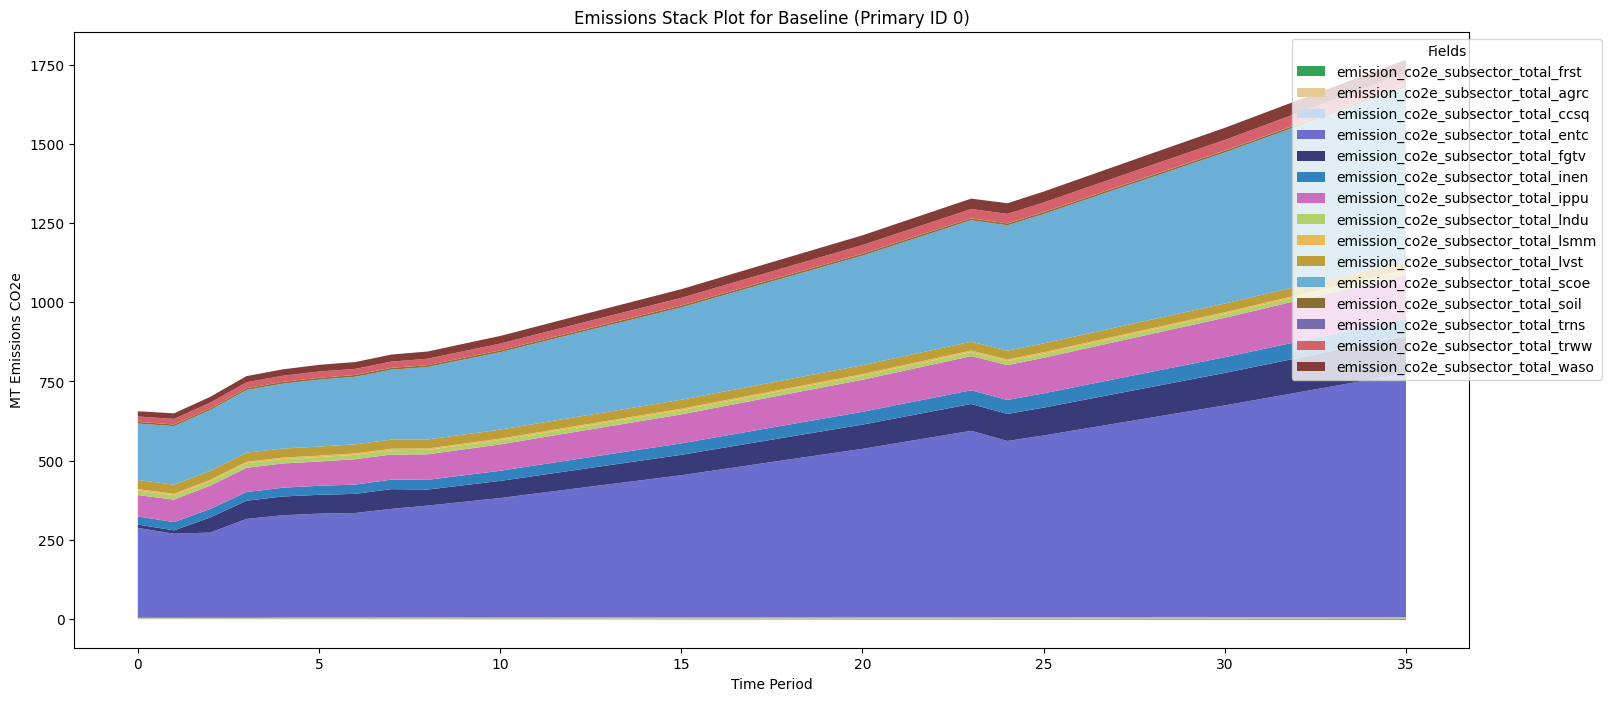

In [31]:
# Plot the emissions stack for the primary_id 0 (which is the baseline)
plot_field_stack(
    df_out,
    subsector_emission_fields,
    dict_format,
    primary_id=0,
    title="Emissions Stack Plot for Baseline (Primary ID 0)"
)

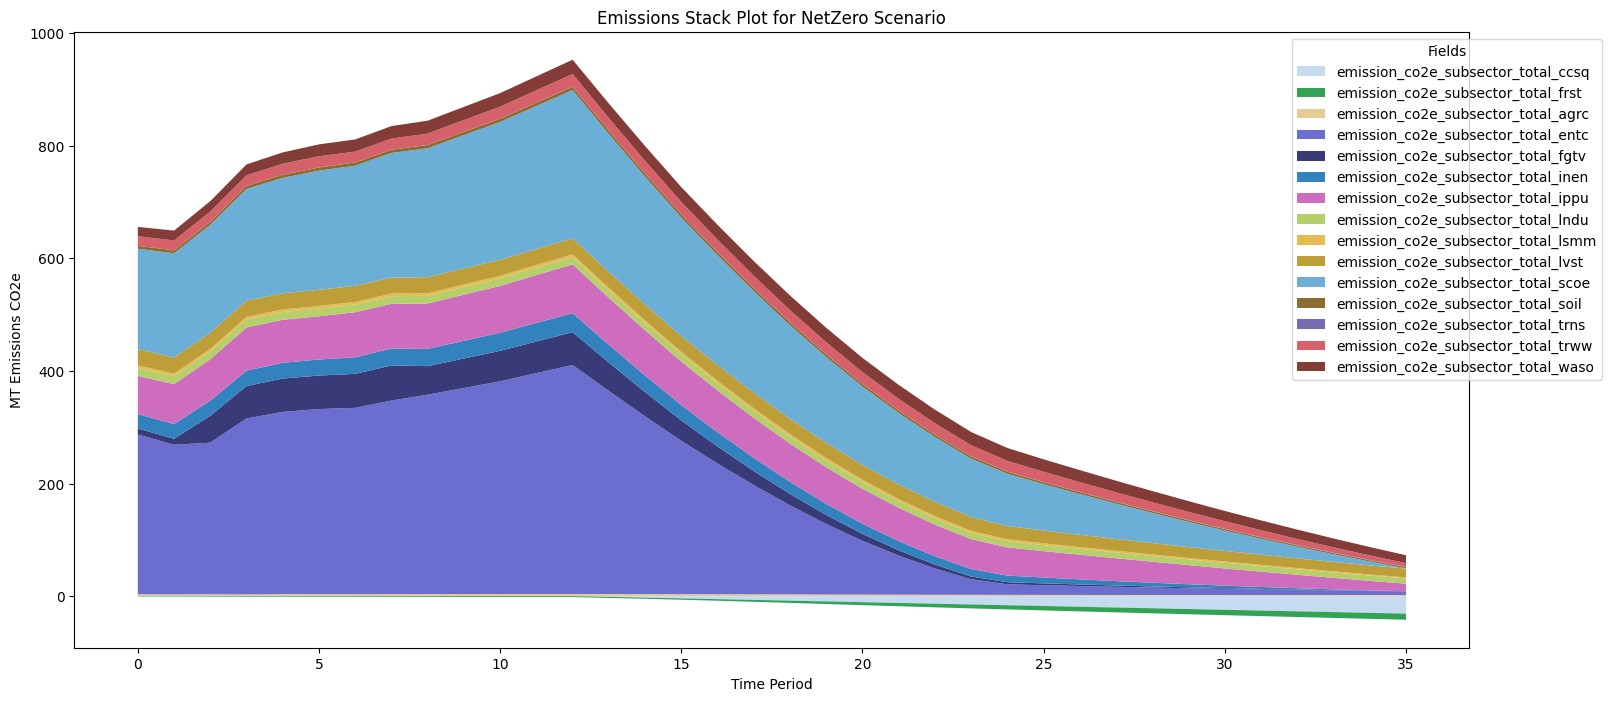

In [32]:
# Plot the emissions stack
plot_field_stack(
    df_out,
    subsector_emission_fields,
    dict_format,
    primary_id=70070,
    title="Emissions Stack Plot for NetZero Scenario"
)

# Export Wide File (Last Mandatory Step)

In [33]:
all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [34]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/opt/miniconda3/envs/ssp_egypt_env/lib/python3.11/site-packages/sisepuede/out'

In [35]:
RUN_ID_OUTPUT_DIR_PATH = os.path.join(
    RUN_OUTPUT_DIR_PATH, 
    f"sisepuede_results_run_{ssp.id_fs_safe}"
)

os.makedirs(RUN_ID_OUTPUT_DIR_PATH, exist_ok=True)

df_primary.to_csv(
    os.path.join(RUN_ID_OUTPUT_DIR_PATH, "ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(RUN_ID_OUTPUT_DIR_PATH, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(RUN_ID_OUTPUT_DIR_PATH, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        logger.warning(f"Warning: Table {tab} returned None.")